In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import gc
from os import listdir
from os.path import isfile, join
import glob

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

In [2]:
def box_cox(Y):
    Y = Y.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(1, 2))
    scaler.fit(Y)
    Y = scaler.transform(Y)

    # Fit BoxCox on the training dataset
    transform = PowerTransformer(method='box-cox')  # Only works with strictly positive values !
    transform.fit(Y)
    return transform.transform(Y)

In [3]:
def normalize(X):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X))

In [21]:
# Define the search grids

logistic_regr_grid = {'n_jobs': [-1],
                      'tol': [1e-6, 1e-4, 1e-2],
                      'C': [0.1, 1, 10],
                      'max_iter': [100, 200, 400]}

random_forest_regr_grid = {'n_jobs': [-1],
                           'n_estimators': [100],
                           'max_depth': [4, 8, 16, 100],
                           'max_features': []}  # Depends on the dataset

random_forest_class_grid = {'n_jobs': [-1],
                            'n_estimators': [100],
                            'max_depth': [4, 8, 16, 100],
                            'max_features': []}  # Depends on the dataset

xgboost_regr_grid = {'n_jobs': [-1],
                     'n_estimators': [100],
                     'max_depth': [8],
                     'learning_rate': [0.01, 0.1, 0.3]}

xgboost_class_grid = {}

decision_tree_regr_grid = {'max_depth': [4, 8, 16, 32, 64],
                           'max_features': []}  # Depends on the dataset

In [8]:
# List the dataset's directories

datasets_directories = [x[0] for x in os.walk('../data/cleaned/')][1:]
print(str(len(datasets_directories)) + " folders found")

27 folders found


In [9]:
# Get the datasets inside the folders

datasets_paths = [glob.glob(dataset_directory + '/*.csv')[0] for dataset_directory in datasets_directories]

# Sort alphabetically
datasets_paths = sorted(datasets_paths)

print(str(len(datasets_paths)) + " datasets found")

27 datasets found


In [10]:
# Get the index files inside the folders

indexes_paths = [glob.glob(dataset_directory + '/*.index')[0] for dataset_directory in datasets_directories]

# Sort alphabetically
indexes_paths = sorted(indexes_paths)

print(str(len(indexes_paths)) + " index files found")

27 index files found


In [11]:
def generate_2_heatmaps(results_grid, param_1, param_2, param_3):
    pvt_1 = pd.pivot_table(pd.DataFrame(results_grid), values='mean_test_score', index=param_1, columns=param_2)
    pvt_2 = pd.pivot_table(pd.DataFrame(results_grid), values='mean_test_score', index=param_2, columns=param_3)

    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    sns.heatmap(pvt_1, annot=True, ax=ax[0])
    sns.heatmap(pvt_2, annot=True, ax=ax[1])
    plt.show()

In [12]:
def generate_heatmap(results_grid, param_1, param_2):
    pvt_1 = pd.pivot_table(pd.DataFrame(results_grid), values='mean_test_score', index=param_1, columns=param_2)

    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    sns.heatmap(pvt_1, annot=True, ax=ax[0])
    plt.show()

├── Air_Quality_Dataset (target index = 1)
│   ├── RandomForestRegressor...
       {'max_depth': 4, 'max_features': 6, 'n_estimators': 100, 'n_jobs': -1}


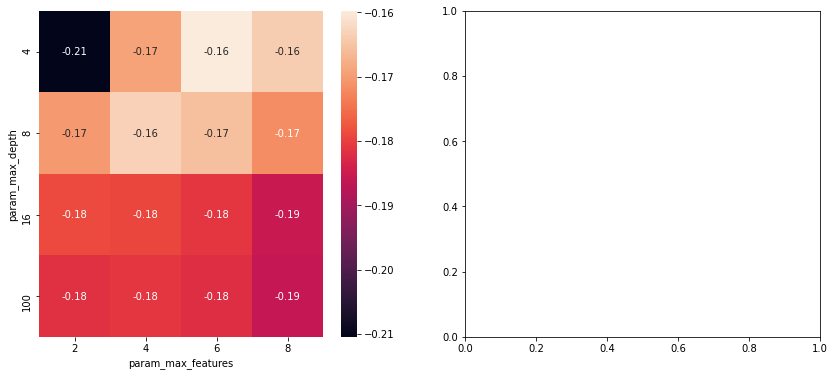

├── Airfoil_Self-Noise_Dataset (target index = 5)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 3, 'n_estimators': 100, 'n_jobs': -1}


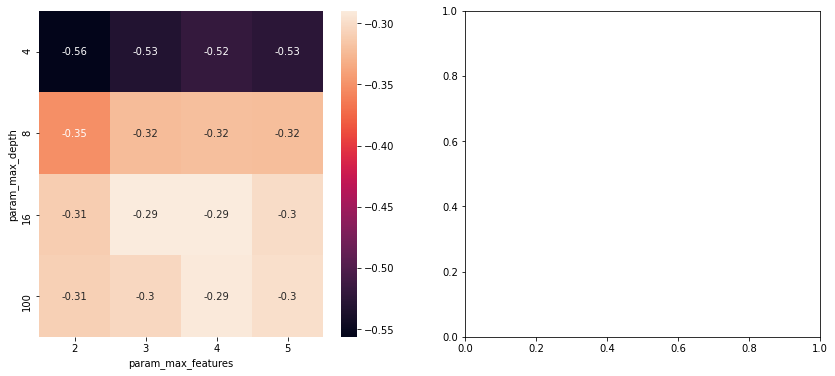

├── Appliances_energy_prediction_Dataset (target index = 0)
│   ├── RandomForestRegressor...
       {'max_depth': 4, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


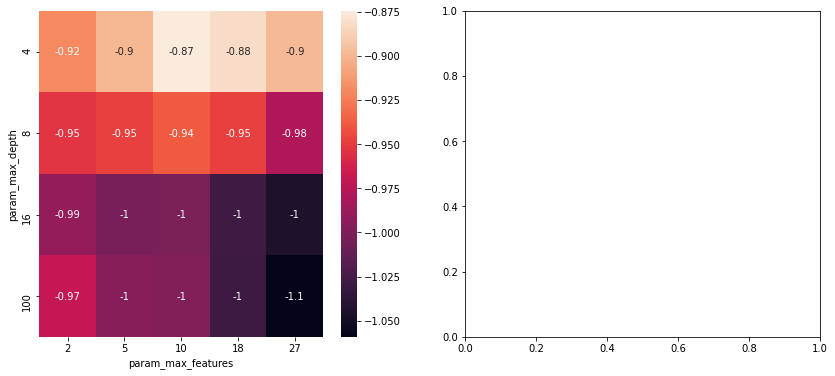

├── Beijing_PM2.5_Data_Dataset (target index = 4)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 6, 'n_estimators': 100, 'n_jobs': -1}


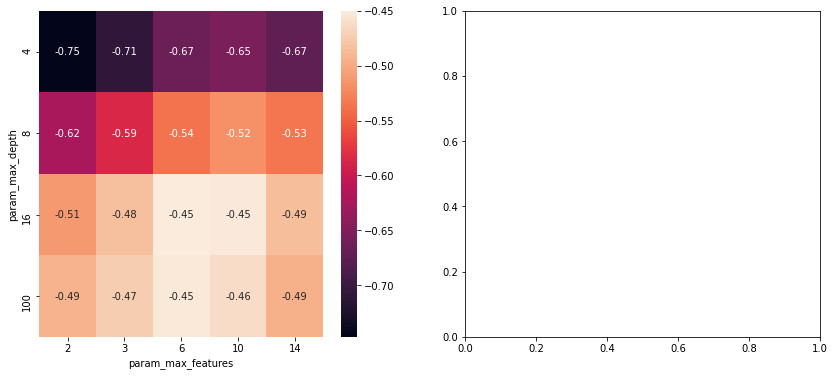

├── Bias_correction_ucl (target index = 22)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 15, 'n_estimators': 100, 'n_jobs': -1}


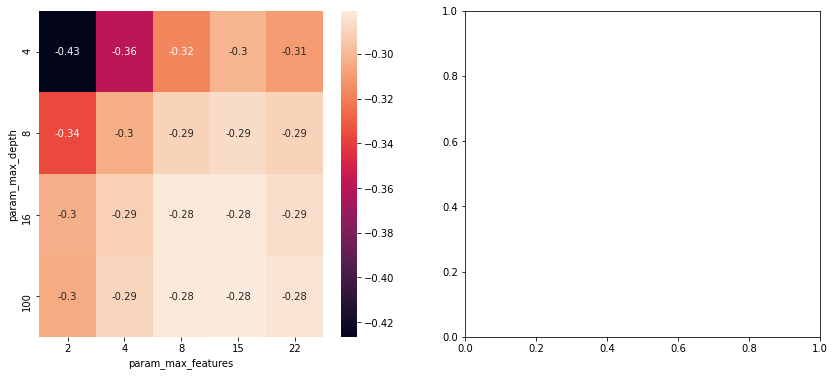

├── Bike_Sharing_Dataset (target index = 8)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 11, 'n_estimators': 100, 'n_jobs': -1}


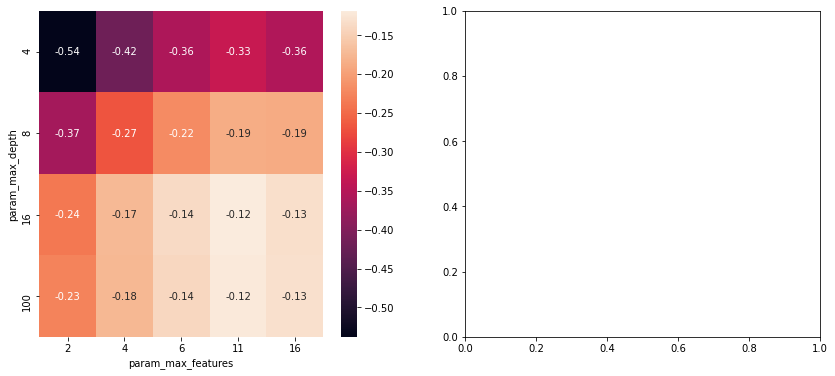

In [23]:
for dataset_path, index_path in zip(datasets_paths[1:7], indexes_paths[1:7]):
    target_var_index = None
    with open(index_path) as f:
        target_var_index = int(f.readline())
        
    print('├── ' + dataset_path.split('/')[3] + ' (target index = ' + str(target_var_index) + ')')
    full_data = pd.read_csv(dataset_path)
    X = full_data.drop(full_data.columns[target_var_index], axis=1)
    Y = full_data[full_data.columns[target_var_index]]
    
    X = normalize(X)
    Y = box_cox(Y)
    Y = Y.ravel()
    
    print('│   ├── RandomForestRegressor...')
    values_to_explore = list(map(int, np.linspace(2, X.shape[1], num=4)))
    values_to_explore.append(int(np.sqrt(X.shape[1])))
    values_to_explore = np.unique(values_to_explore)
    random_forest_regr_grid['max_features'] = values_to_explore
    
    grid = GridSearchCV(estimator = RandomForestRegressor(),
                        param_grid = random_forest_regr_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X, Y)
    
    print('       ' + str(grid.best_params_))
    generate_heatmap(grid.cv_results_, 'param_max_depth', 'param_max_features')
    
    # del grid
    # gc.collect()
    
    # print('│   └── XGBRegressor...')
    # grid = GridSearchCV(estimator = XGBRegressor(),
    #                     param_grid = xgboost_regr_grid,
    #                     scoring = 'neg_mean_squared_error',
    #                     n_jobs=-1)
    # grid.fit(X, Y)
    # 
    # print('       ' + str(grid.best_params_))
    # generate_2_heatmaps(grid.cv_results_, 'param_n_estimators', 'param_max_depth', 'param_learning_rate')
    
    del grid, X, Y, full_data
    gc.collect()

├── Combined_Cycle_Power_Plant_Dataset (target index = 4)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 2, 'n_estimators': 100, 'n_jobs': -1}


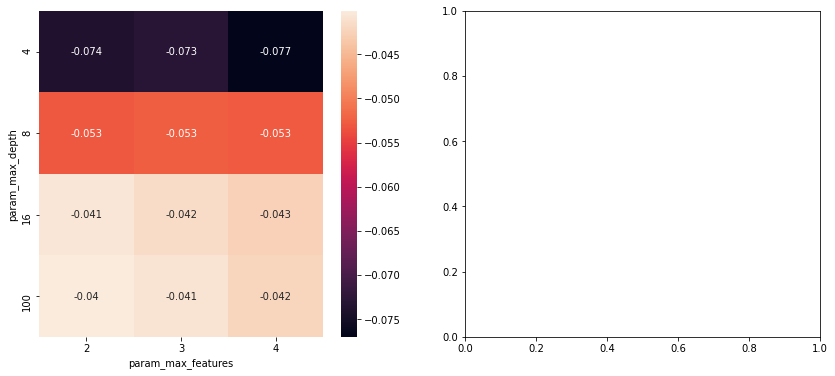

├── Communities_and_Crime_Dataset (target index = 122)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 82, 'n_estimators': 100, 'n_jobs': -1}


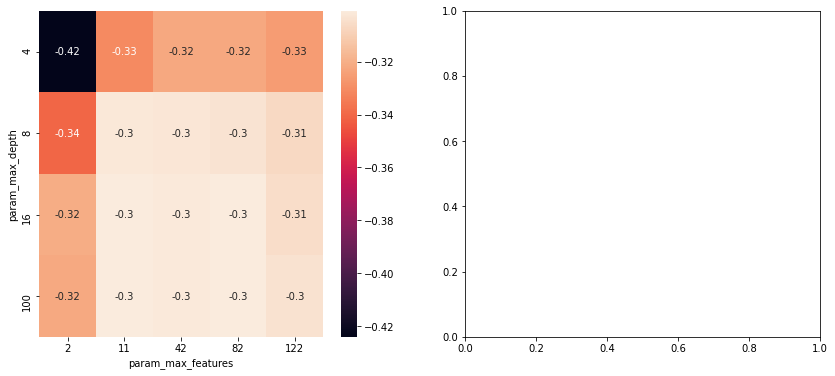

├── Communities_and_Crime_Unnormalized_Dataset (target index = 124)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 42, 'n_estimators': 100, 'n_jobs': -1}


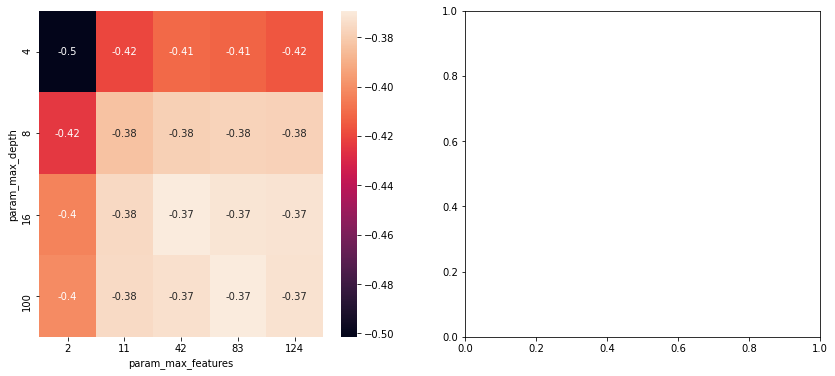

├── Concrete_Compressive_Strength_Dataset (target index = 8)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 4, 'n_estimators': 100, 'n_jobs': -1}


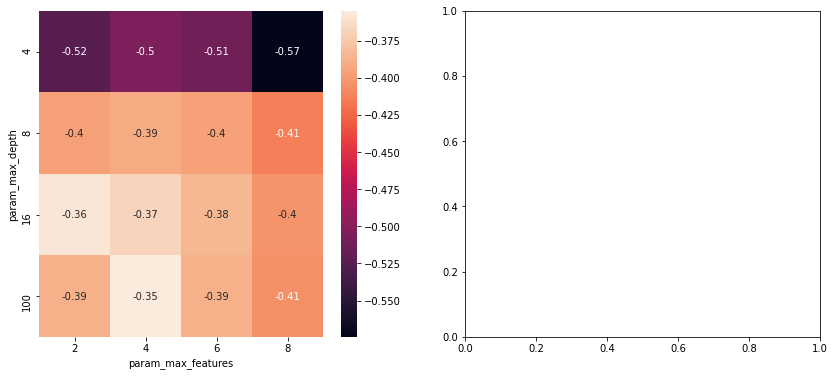

├── Condition_Based_Maintenance_of_Naval_Propulsion_Plants_Dataset (target index = 15)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 6, 'n_estimators': 100, 'n_jobs': -1}


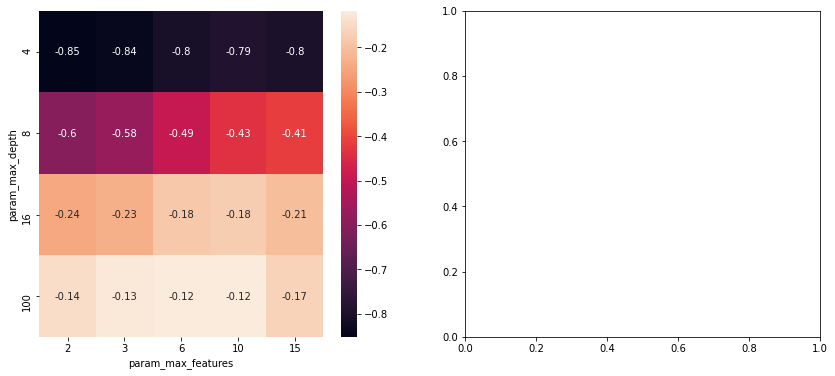

├── Cuff-Less_Blood_Pressure_Estimation_Dataset (target index = 1)
│   ├── RandomForestRegressor...
       {'max_depth': 8, 'max_features': 1, 'n_estimators': 100, 'n_jobs': -1}


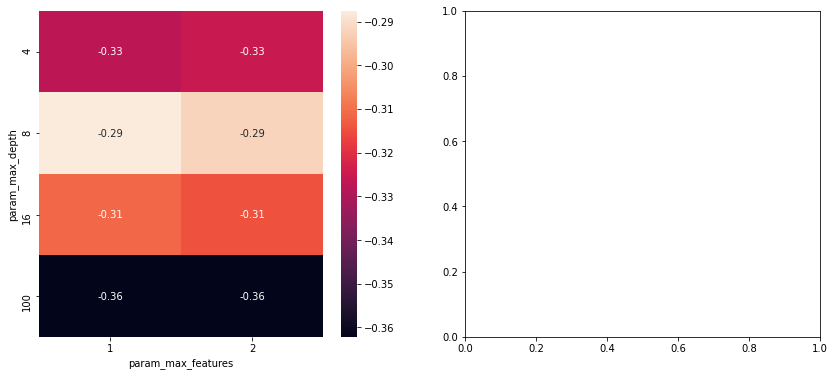

├── Electrical_Grid_Stability_Simulated_Dataset (target index = 12)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 12, 'n_estimators': 100, 'n_jobs': -1}


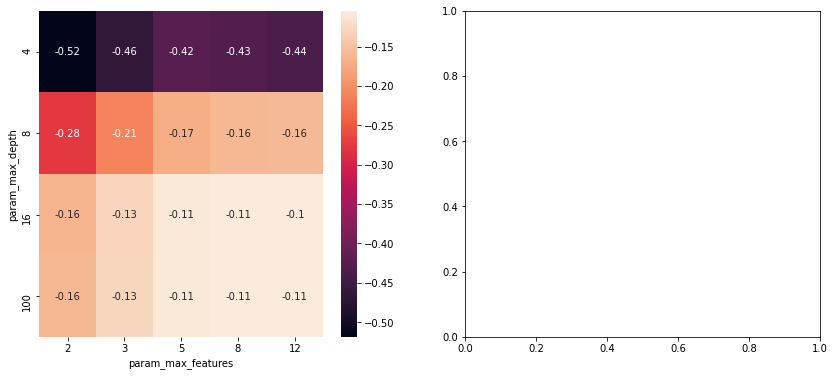

├── Facebook_Comment_Volume_Dataset (target index = 53)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 36, 'n_estimators': 100, 'n_jobs': -1}


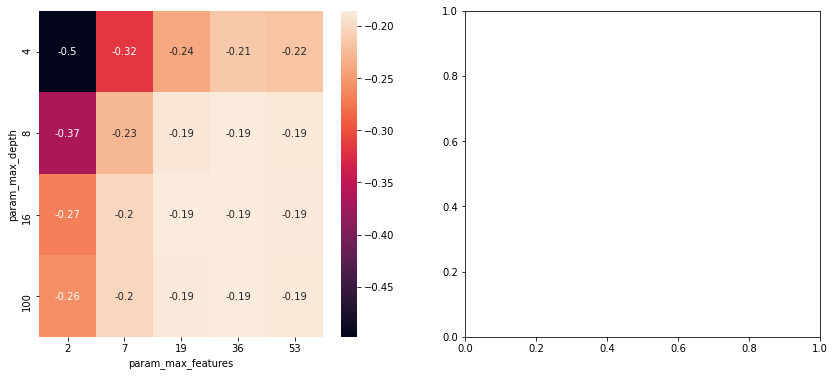

├── Geographical_Original_of_Music_Dataset (target index = 116)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 116, 'n_estimators': 100, 'n_jobs': -1}


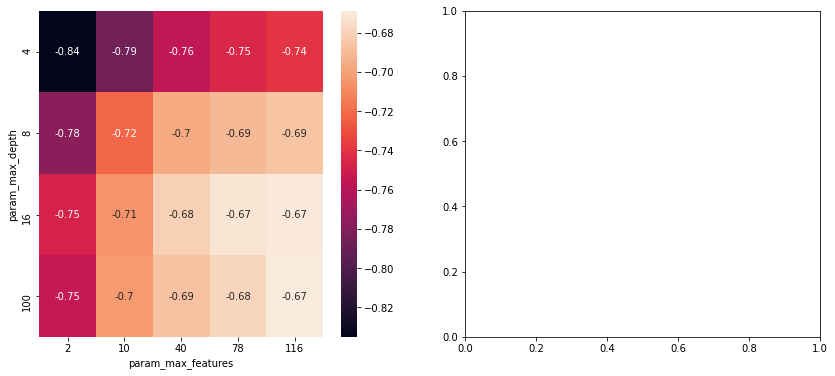

├── Greenhouse_Gas_Observing_Network_Dataset (target index = 15)
│   ├── RandomForestRegressor...


In [ ]:
for dataset_path, index_path in zip(datasets_paths[9:], indexes_paths[9:]):
    target_var_index = None
    with open(index_path) as f:
        target_var_index = int(f.readline())
        
    print('├── ' + dataset_path.split('/')[3] + ' (target index = ' + str(target_var_index) + ')')
    full_data = pd.read_csv(dataset_path)
    X = full_data.drop(full_data.columns[target_var_index], axis=1)
    Y = full_data[full_data.columns[target_var_index]]
    
    X = normalize(X)
    Y = box_cox(Y)
    Y = Y.ravel()
    
    print('│   ├── RandomForestRegressor...')
    values_to_explore = list(map(int, np.linspace(2, X.shape[1], num=4)))
    values_to_explore.append(int(np.sqrt(X.shape[1])))
    values_to_explore = np.unique(values_to_explore)
    random_forest_regr_grid['max_features'] = values_to_explore
    
    grid = GridSearchCV(estimator = RandomForestRegressor(),
                        param_grid = random_forest_regr_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X, Y)
    
    print('       ' + str(grid.best_params_))
    generate_heatmap(grid.cv_results_, 'param_max_depth', 'param_max_features')
    
    # del grid
    # gc.collect()
    
    # print('│   └── XGBRegressor...')
    # grid = GridSearchCV(estimator = XGBRegressor(),
    #                     param_grid = xgboost_regr_grid,
    #                     scoring = 'neg_mean_squared_error',
    #                     n_jobs=-1)
    # grid.fit(X, Y)
    # 
    # print('       ' + str(grid.best_params_))
    # generate_2_heatmaps(grid.cv_results_, 'param_n_estimators', 'param_max_depth', 'param_learning_rate')
    
    del grid, X, Y, full_data
    gc.collect()

├── KEGG_Metabolic_Reaction_Network_(Undirected)_Dataset (target index = 27)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


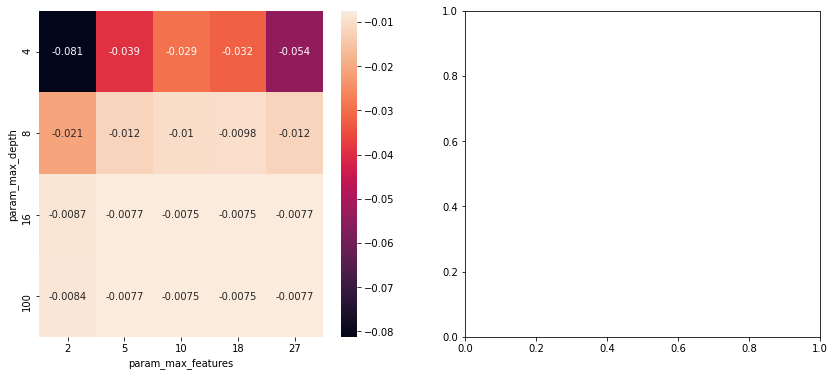

├── KEGG_Metabolic_Relation_Network_(Directed)_Dataset (target index = 22)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 15, 'n_estimators': 100, 'n_jobs': -1}


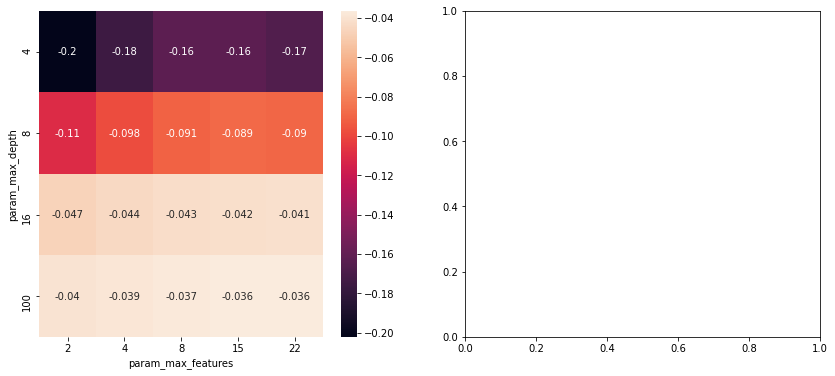

├── Online_News_Popularity_Dataset (target index = 59)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 7, 'n_estimators': 100, 'n_jobs': -1}


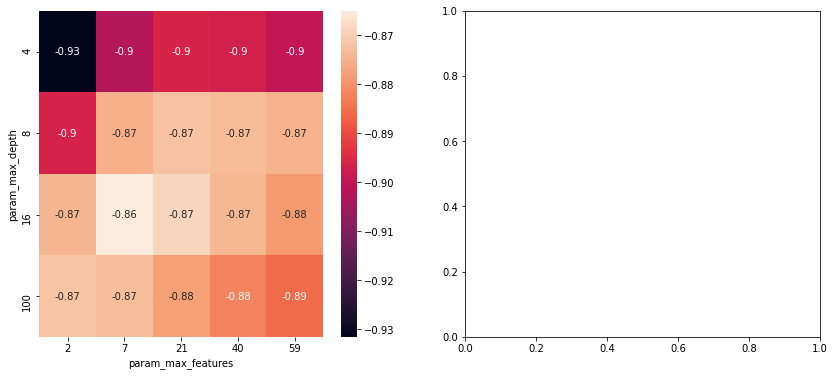

├── Online_Video_Characteristics_and_Transcoding_Time_Dataset (target index = 18)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


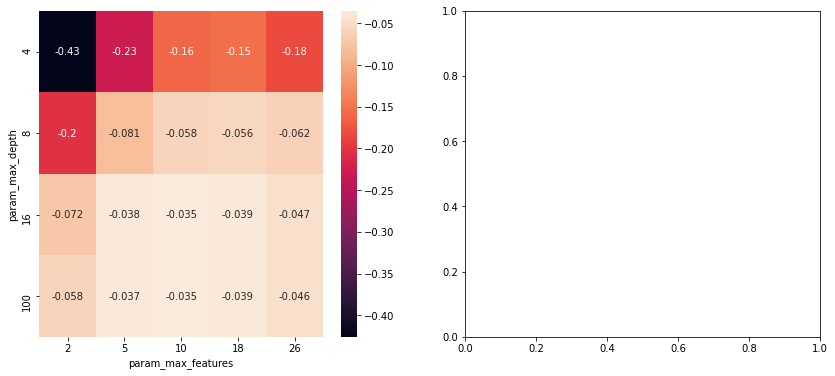

├── PM2.5_Data_of_Five_Chinese_Cities_Dataset (target index = 4)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 2, 'n_estimators': 100, 'n_jobs': -1}


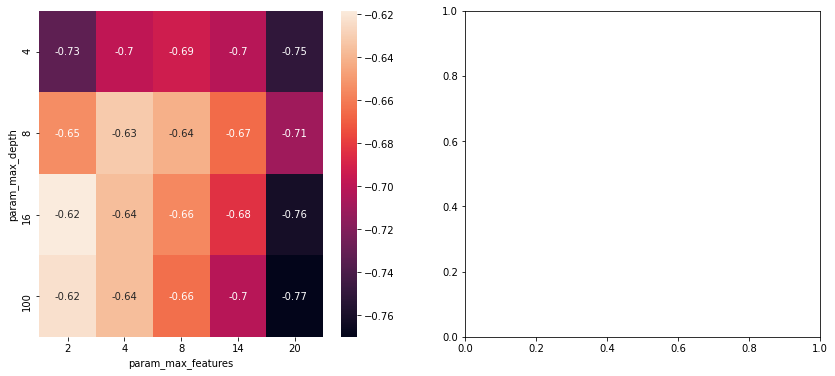

├── Parkinson_Speech_Dataset_with_Multiple_Types_of_Sound_Recordings_Dataset (target index = 26)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 2, 'n_estimators': 100, 'n_jobs': -1}


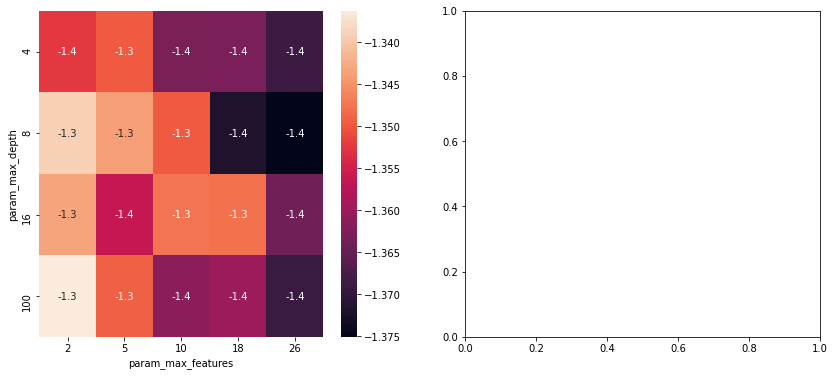

├── Parkinsons_Telemonitoring_Dataset (target index = 0)
│   ├── RandomForestRegressor...
       {'max_depth': 4, 'max_features': 2, 'n_estimators': 100, 'n_jobs': -1}


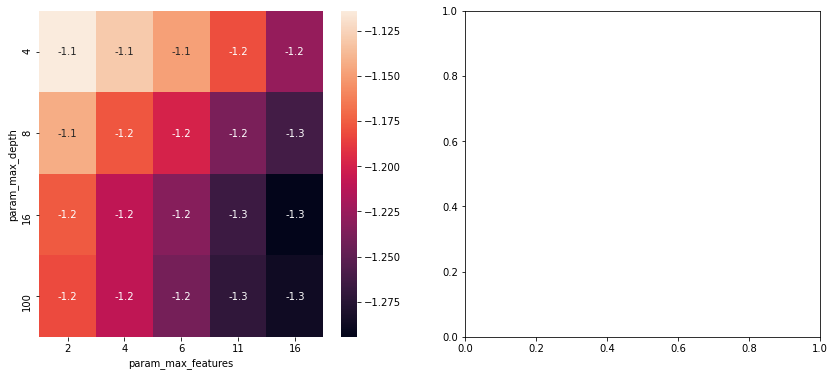

├── Physicochemical_Properties_of_Protein_Tertiary_Structure_Dataset (target index = 0)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 6, 'n_estimators': 100, 'n_jobs': -1}


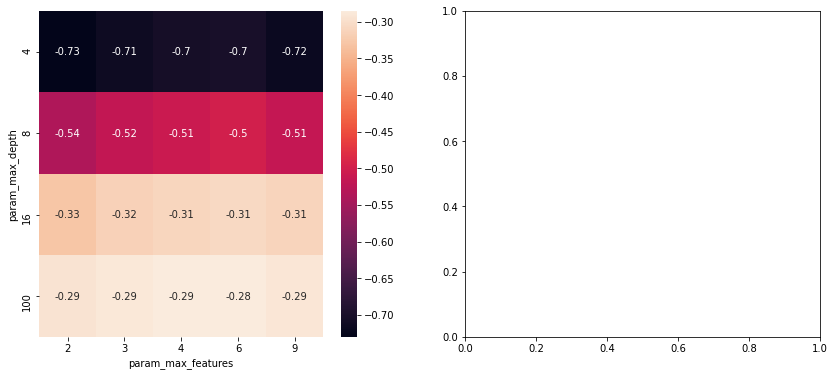

├── Production_quality (target index = 17)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 12, 'n_estimators': 100, 'n_jobs': -1}


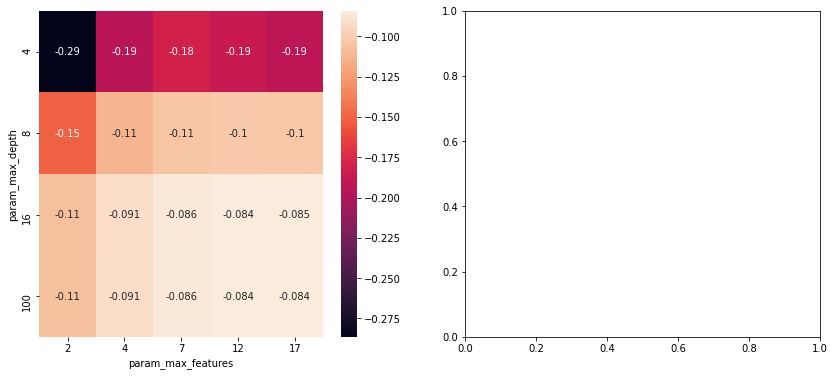

├── Relative_location_of_CT_slices_on_axial_axis_Dataset (target index = 384)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 129, 'n_estimators': 100, 'n_jobs': -1}


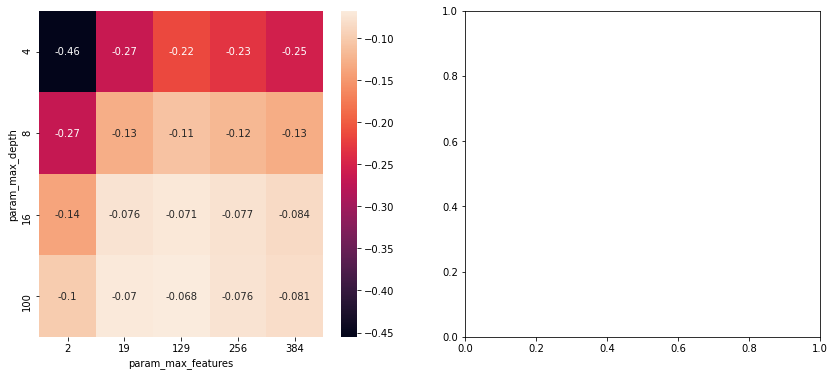

├── SGEMM_GPU_kernel_performance_Dataset (target index = 14)
│   ├── RandomForestRegressor...


In [ ]:
for dataset_path, index_path in zip(datasets_paths[20:], indexes_paths[20:]):
    target_var_index = None
    with open(index_path) as f:
        target_var_index = int(f.readline())
        
    print('├── ' + dataset_path.split('/')[3] + ' (target index = ' + str(target_var_index) + ')')
    full_data = pd.read_csv(dataset_path)
    X = full_data.drop(full_data.columns[target_var_index], axis=1)
    Y = full_data[full_data.columns[target_var_index]]
    
    X = normalize(X)
    Y = box_cox(Y)
    Y = Y.ravel()
    
    print('│   ├── RandomForestRegressor...')
    values_to_explore = list(map(int, np.linspace(2, X.shape[1], num=4)))
    values_to_explore.append(int(np.sqrt(X.shape[1])))
    values_to_explore = np.unique(values_to_explore)
    random_forest_regr_grid['max_features'] = values_to_explore
    
    grid = GridSearchCV(estimator = RandomForestRegressor(),
                        param_grid = random_forest_regr_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X, Y)
    
    print('       ' + str(grid.best_params_))
    generate_heatmap(grid.cv_results_, 'param_max_depth', 'param_max_features')
    
    # del grid
    # gc.collect()
    
    # print('│   └── XGBRegressor...')
    # grid = GridSearchCV(estimator = XGBRegressor(),
    #                     param_grid = xgboost_regr_grid,
    #                     scoring = 'neg_mean_squared_error',
    #                     n_jobs=-1)
    # grid.fit(X, Y)
    # 
    # print('       ' + str(grid.best_params_))
    # generate_2_heatmaps(grid.cv_results_, 'param_n_estimators', 'param_max_depth', 'param_learning_rate')
    
    del grid, X, Y, full_data
    gc.collect()

├── SML2010_Dataset (target index = 0)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 18, 'n_estimators': 100, 'n_jobs': -1}


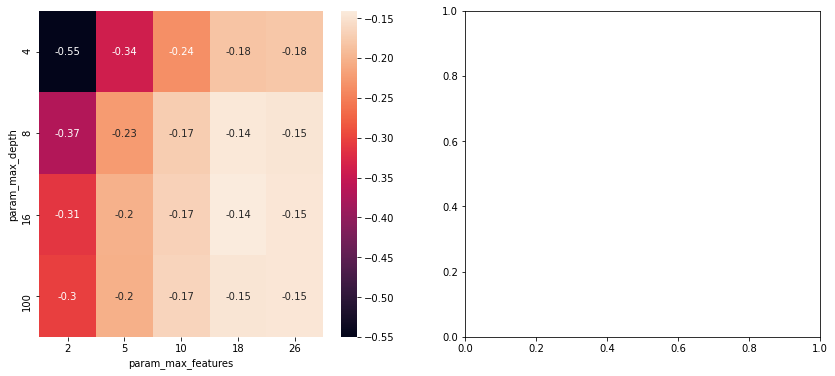

├── Seoul_Bike_Sharing_Demand_Dataset (target index = 0)
│   ├── RandomForestRegressor...
       {'max_depth': 8, 'max_features': 6, 'n_estimators': 100, 'n_jobs': -1}


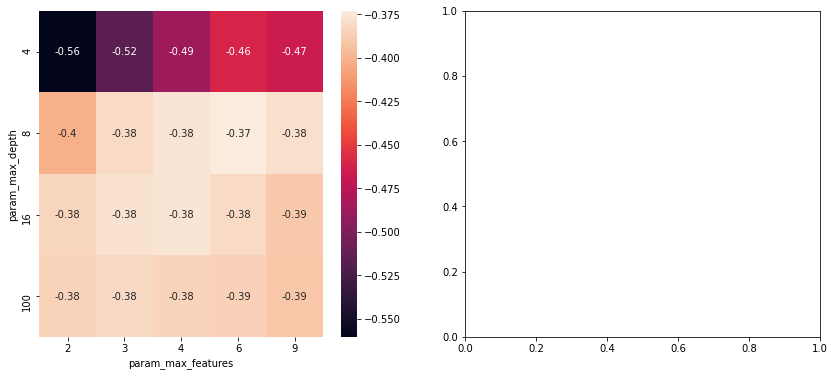

├── UJIIndoorLoc_Dataset (target index = 520)
│   ├── RandomForestRegressor...
       {'max_depth': 16, 'max_features': 352, 'n_estimators': 100, 'n_jobs': -1}


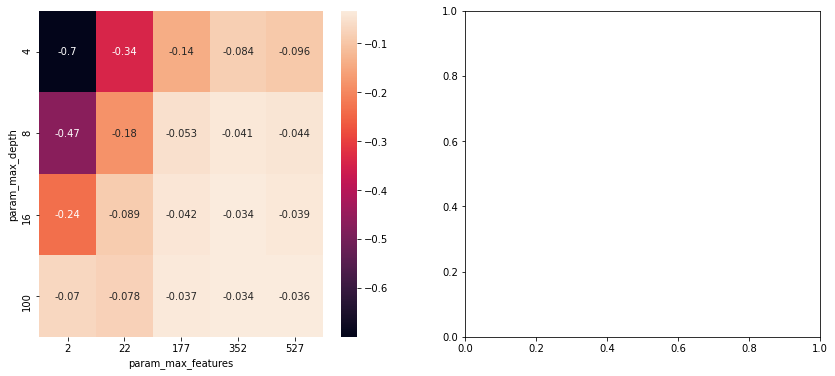

├── Uber_location_price_data (target index = 0)
│   ├── RandomForestRegressor...
       {'max_depth': 100, 'max_features': 2, 'n_estimators': 100, 'n_jobs': -1}


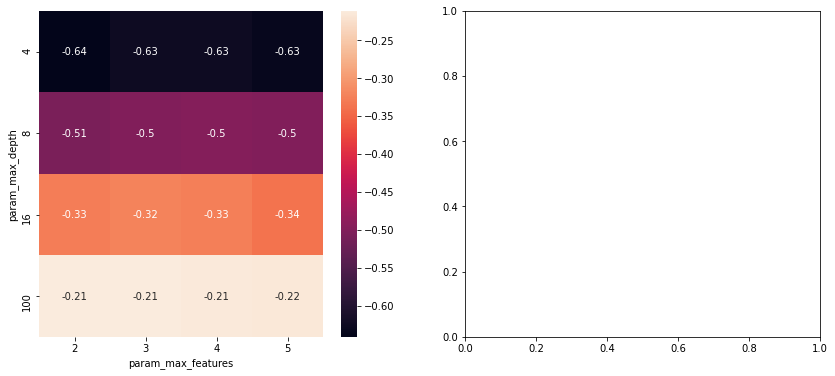

├── YearPredictionMSD_Dataset (target index = 0)
│   ├── RandomForestRegressor...


KeyboardInterrupt: 

In [30]:
for dataset_path, index_path in zip(datasets_paths[31:], indexes_paths[31:]):
    target_var_index = None
    with open(index_path) as f:
        target_var_index = int(f.readline())
        
    print('├── ' + dataset_path.split('/')[3] + ' (target index = ' + str(target_var_index) + ')')
    full_data = pd.read_csv(dataset_path)
    X = full_data.drop(full_data.columns[target_var_index], axis=1)
    Y = full_data[full_data.columns[target_var_index]]
    
    X = normalize(X)
    Y = box_cox(Y)
    Y = Y.ravel()
    
    print('│   ├── RandomForestRegressor...')
    values_to_explore = list(map(int, np.linspace(2, X.shape[1], num=4)))
    values_to_explore.append(int(np.sqrt(X.shape[1])))
    values_to_explore = np.unique(values_to_explore)
    random_forest_regr_grid['max_features'] = values_to_explore
    
    grid = GridSearchCV(estimator = RandomForestRegressor(),
                        param_grid = random_forest_regr_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X, Y)
    
    print('       ' + str(grid.best_params_))
    generate_heatmap(grid.cv_results_, 'param_max_depth', 'param_max_features')
    
    # del grid
    # gc.collect()
    
    # print('│   └── XGBRegressor...')
    # grid = GridSearchCV(estimator = XGBRegressor(),
    #                     param_grid = xgboost_regr_grid,
    #                     scoring = 'neg_mean_squared_error',
    #                     n_jobs=-1)
    # grid.fit(X, Y)
    # 
    # print('       ' + str(grid.best_params_))
    # generate_2_heatmaps(grid.cv_results_, 'param_n_estimators', 'param_max_depth', 'param_learning_rate')
    
    del grid, X, Y, full_data
    gc.collect()

# XGBoost

├── Airfoil_Self-Noise_Dataset (target index = 5)
│   └── XGBRegressor...
       {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'n_jobs': -1}


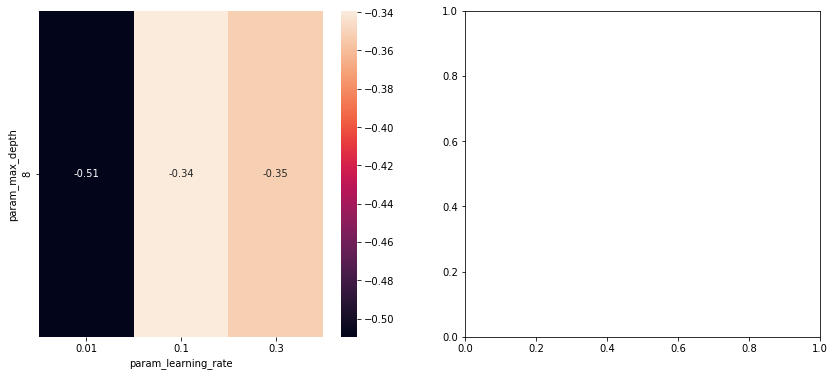

├── Appliances_energy_prediction_Dataset (target index = 0)
│   └── XGBRegressor...


KeyboardInterrupt: 

In [13]:
for dataset_path, index_path in zip(datasets_paths, indexes_paths):
    target_var_index = None
    with open(index_path) as f:
        target_var_index = int(f.readline())

    print('├── ' + dataset_path.split('/')[3] + ' (target index = ' + str(target_var_index) + ')')
    full_data = pd.read_csv(dataset_path)
    X = full_data.drop(full_data.columns[target_var_index], axis=1)
    Y = full_data[full_data.columns[target_var_index]]

    X = normalize(X)
    Y = box_cox(Y)
    Y = Y.ravel()

    print('│   └── XGBRegressor...')
    grid = GridSearchCV(estimator = XGBRegressor(),
                        param_grid = xgboost_regr_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X, Y)

    print('       ' + str(grid.best_params_))
    generate_heatmap(grid.cv_results_, 'param_max_depth', 'param_learning_rate')

    del grid, X, Y, full_data
    gc.collect()

# Decision Tree

├── Air_Quality_Dataset (target index = 1)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 8}


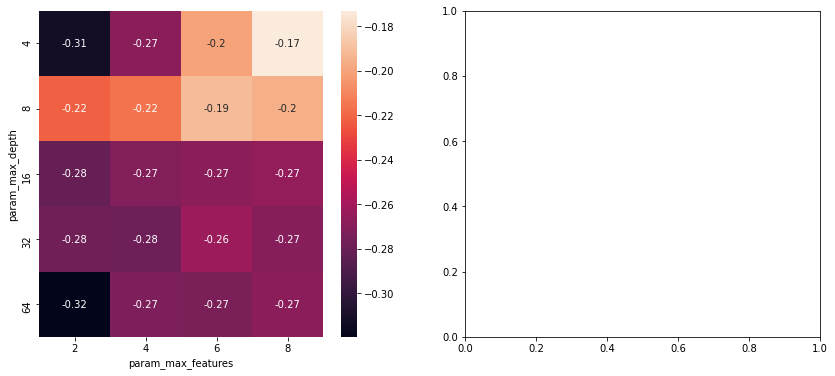

├── Airfoil_Self-Noise_Dataset (target index = 5)
│   └── DecisionTreeRegressor...
       {'max_depth': 16, 'max_features': 4}


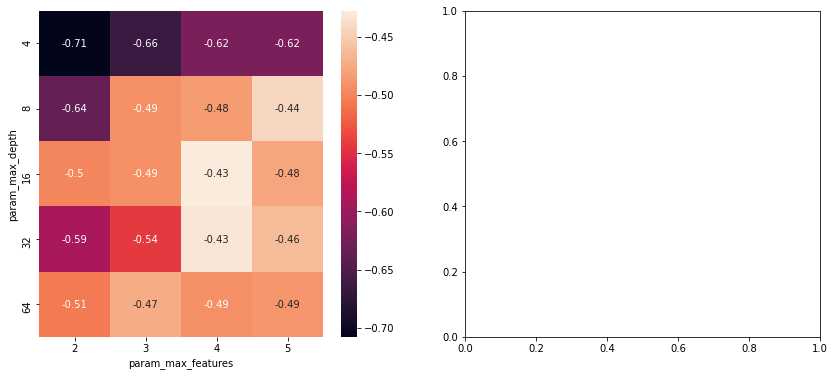

├── Appliances_energy_prediction_Dataset (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 10}


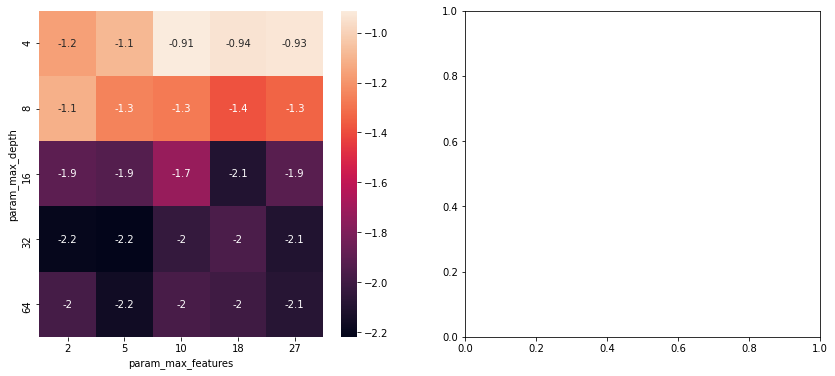

├── Beijing_PM2.5_Data_Dataset (target index = 4)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 14}


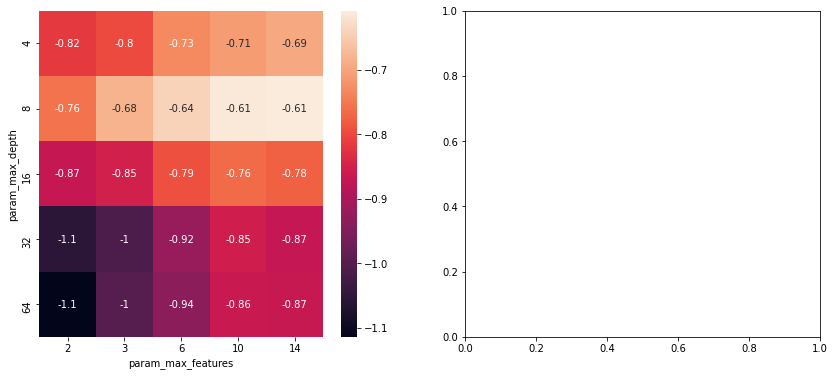

├── Bias_correction_ucl (target index = 22)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 22}


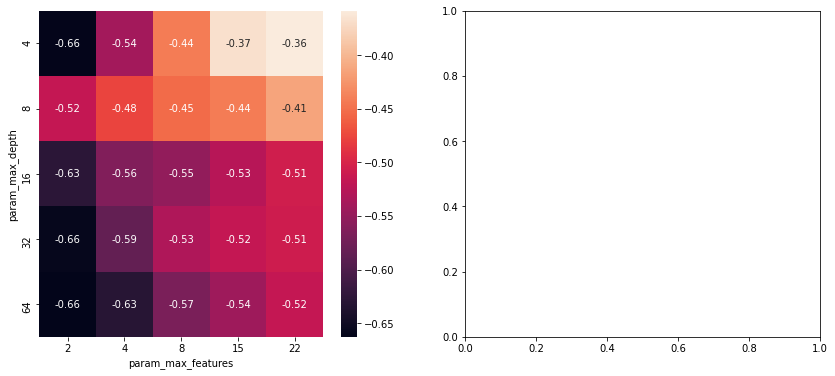

├── Bike_Sharing_Dataset (target index = 8)
│   └── DecisionTreeRegressor...
       {'max_depth': 16, 'max_features': 16}


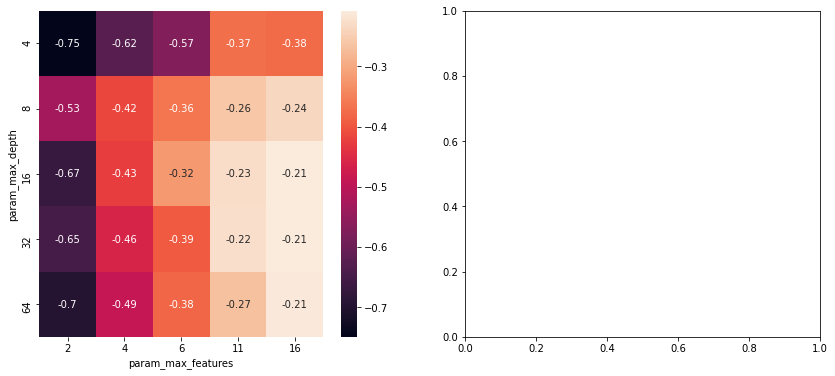

├── BlogFeedback_Dataset (target index = 18)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 18}


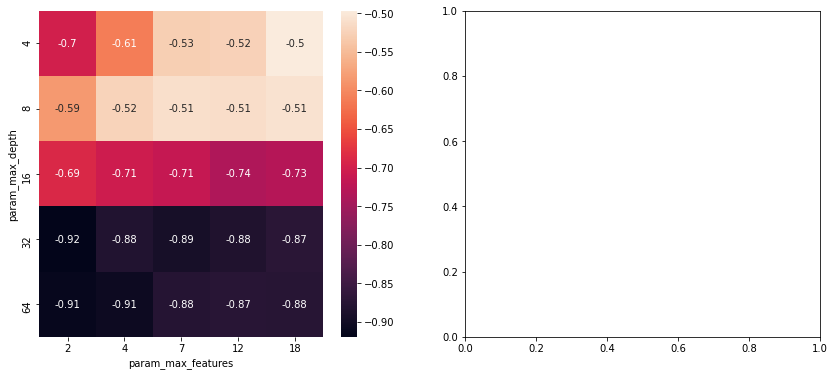

├── Combined_Cycle_Power_Plant_Dataset (target index = 4)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 4}


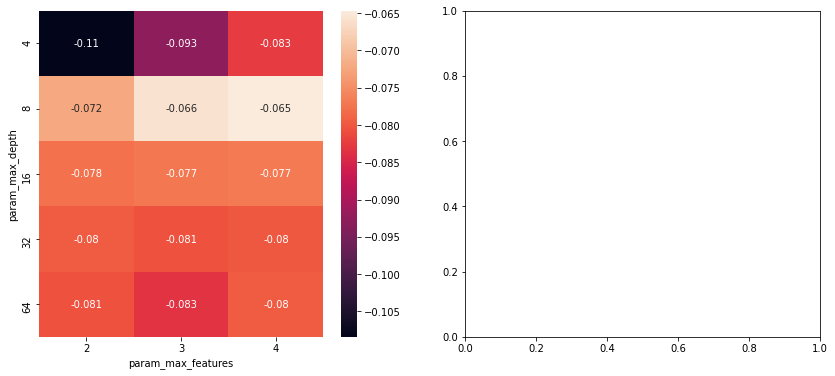

├── Communities_and_Crime_Dataset (target index = 122)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 42}


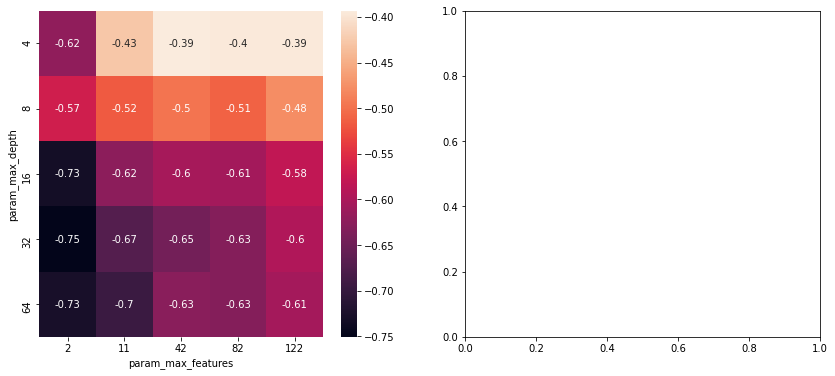

├── Communities_and_Crime_Unnormalized_Dataset (target index = 124)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 124}


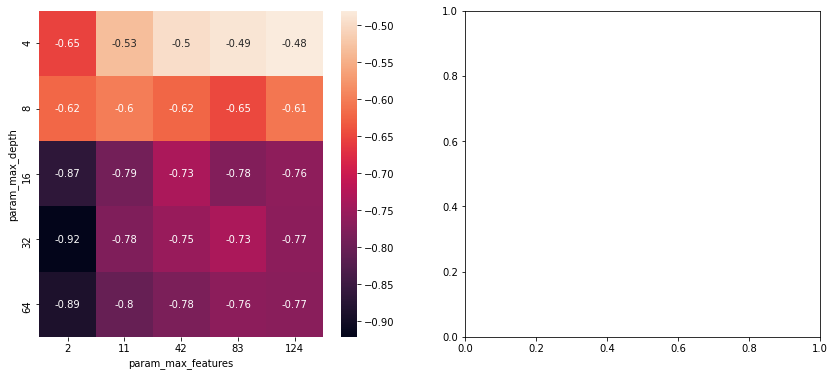

├── Concrete_Compressive_Strength_Dataset (target index = 8)
│   └── DecisionTreeRegressor...
       {'max_depth': 32, 'max_features': 6}


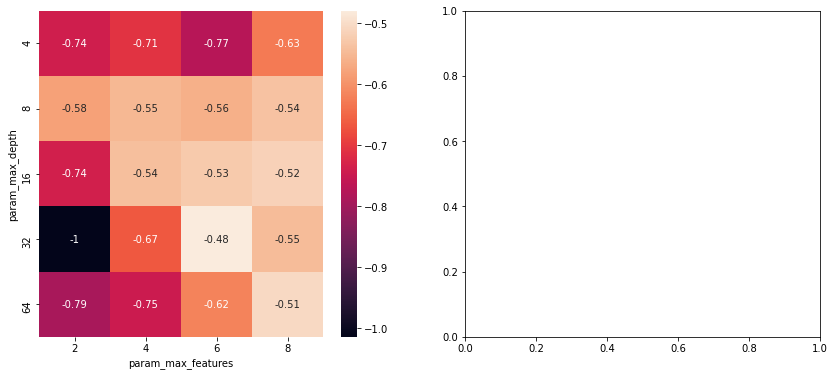

├── Condition_Based_Maintenance_of_Naval_Propulsion_Plants_Dataset (target index = 15)
│   └── DecisionTreeRegressor...
       {'max_depth': 32, 'max_features': 10}


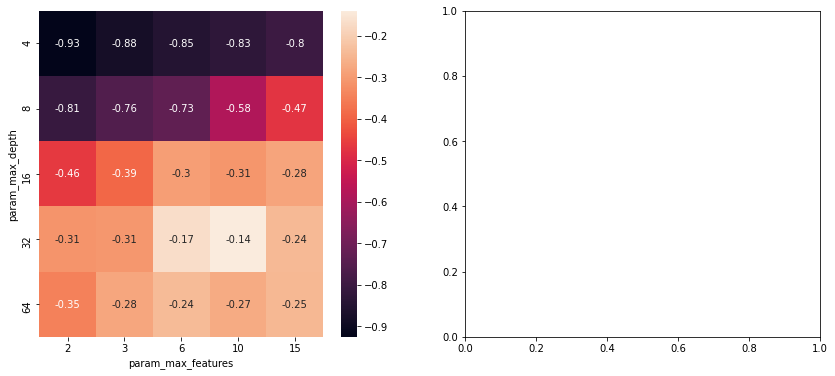

├── Cuff-Less_Blood_Pressure_Estimation_Dataset (target index = 1)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 2}


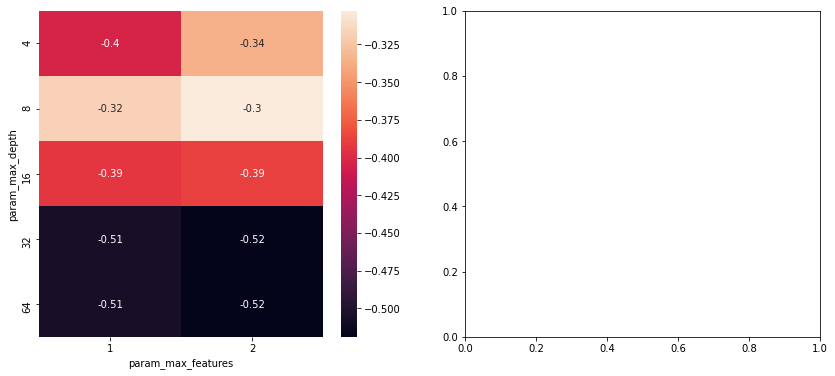

├── Electrical_Grid_Stability_Simulated_Dataset (target index = 12)
│   └── DecisionTreeRegressor...
       {'max_depth': 64, 'max_features': 12}


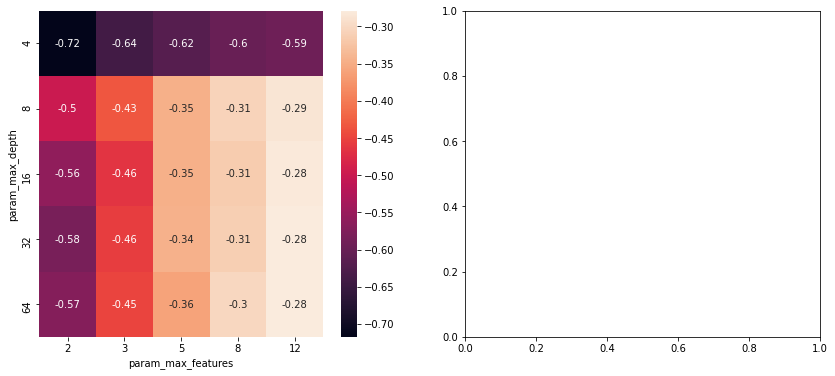

├── Facebook_Comment_Volume_Dataset (target index = 53)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 53}


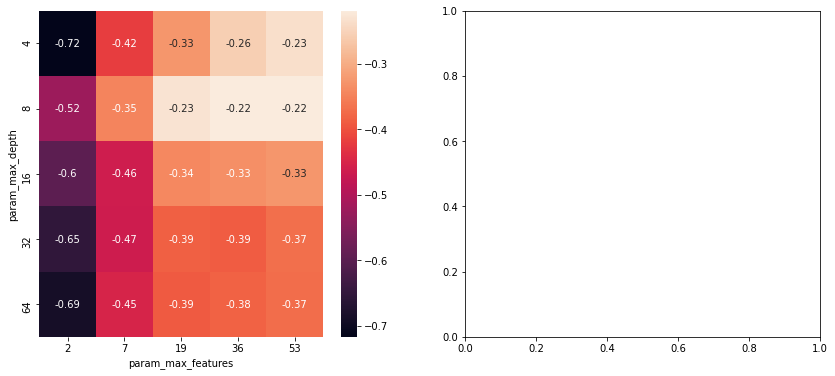

├── Geographical_Original_of_Music_Dataset (target index = 116)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 116}


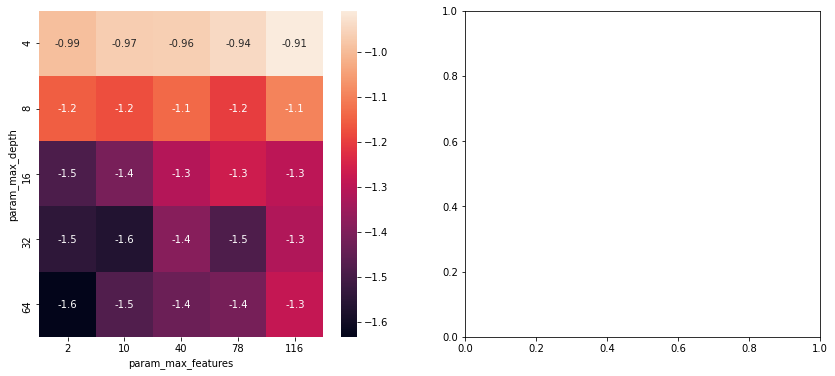

├── Online_Video_Characteristics_and_Transcoding_Time_Dataset (target index = 18)
│   └── DecisionTreeRegressor...
       {'max_depth': 16, 'max_features': 18}


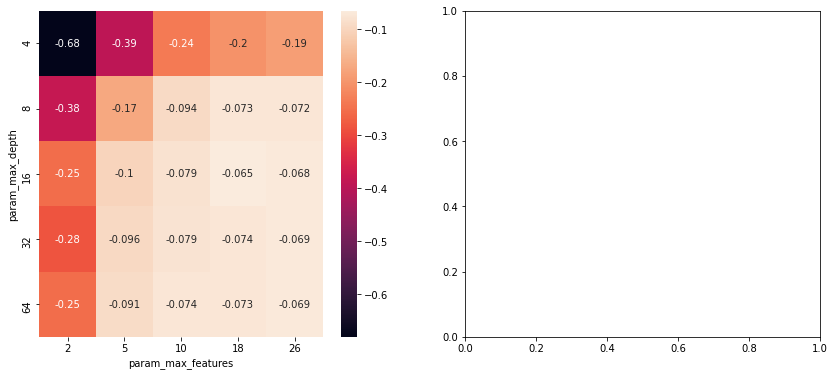

├── PM2.5_Data_of_Five_Chinese_Cities_Dataset (target index = 4)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 14}


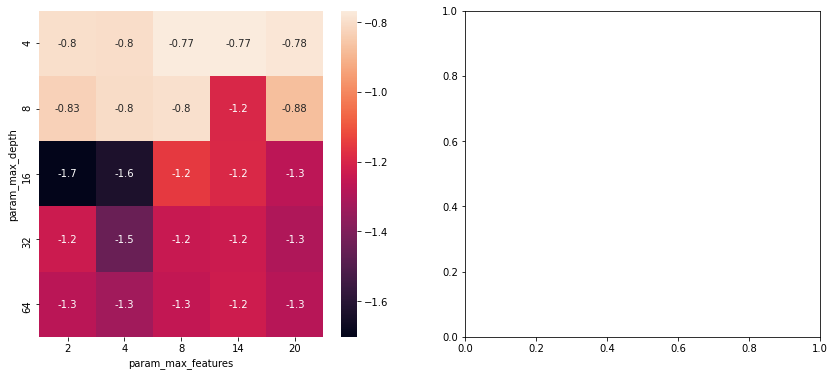

├── Parkinson_Speech_Dataset_with_Multiple_Types_of_Sound_Recordings_Dataset (target index = 26)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 2}


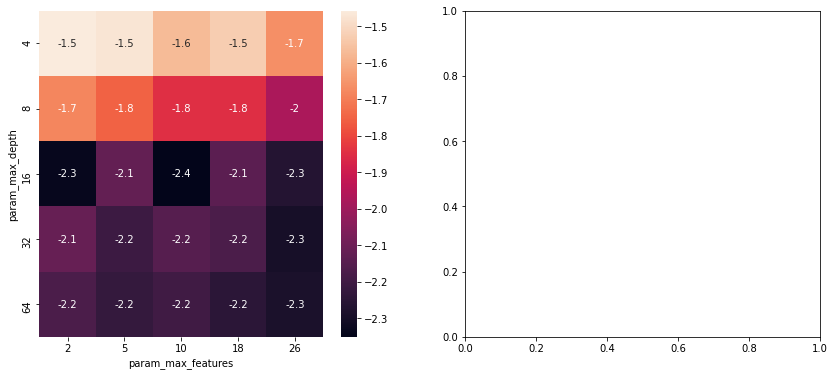

├── Parkinsons_Telemonitoring_Dataset (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 4}


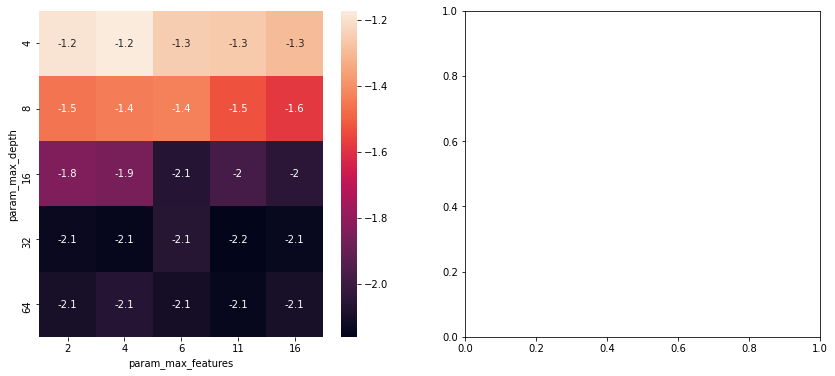

├── Physicochemical_Properties_of_Protein_Tertiary_Structure_Dataset (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 16, 'max_features': 9}


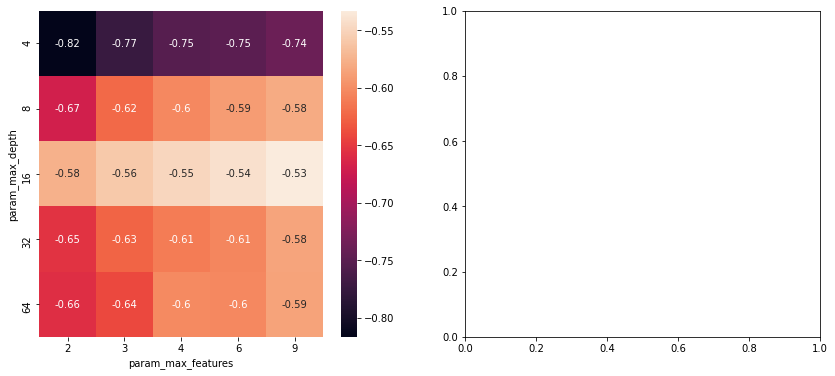

├── Production_quality (target index = 17)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 17}


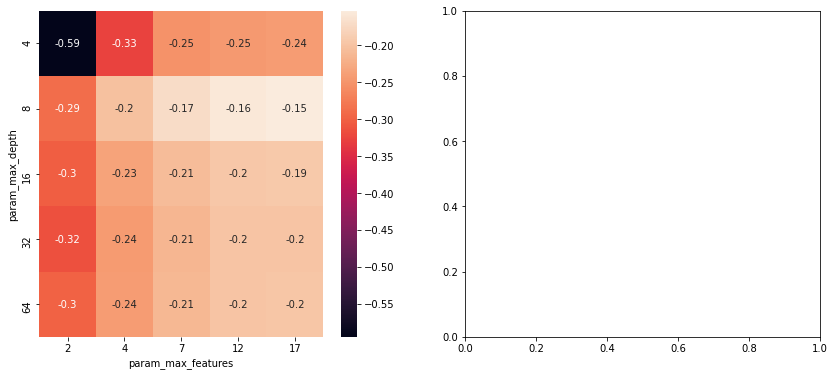

├── SML2010_Dataset (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 4, 'max_features': 26}


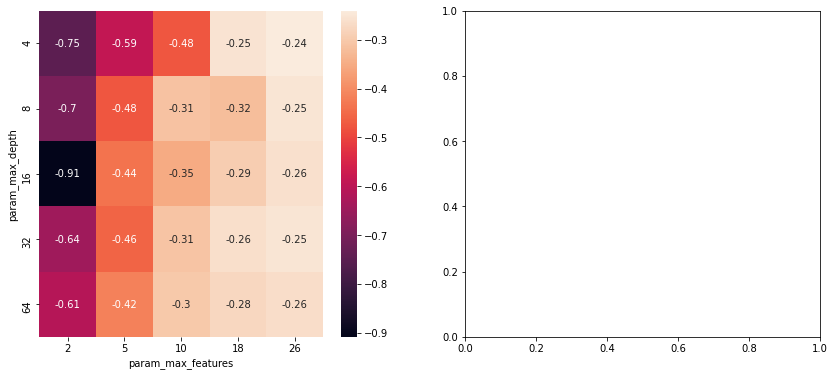

├── Seoul_Bike_Sharing_Demand_Dataset (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 9}


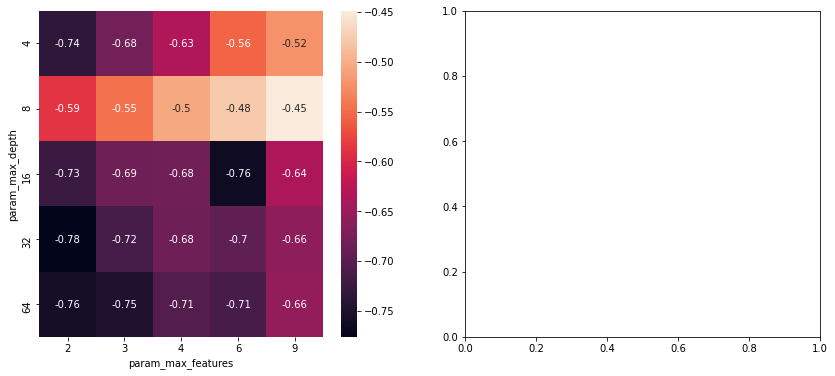

├── UJIIndoorLoc_Dataset (target index = 520)
│   └── DecisionTreeRegressor...
       {'max_depth': 16, 'max_features': 527}


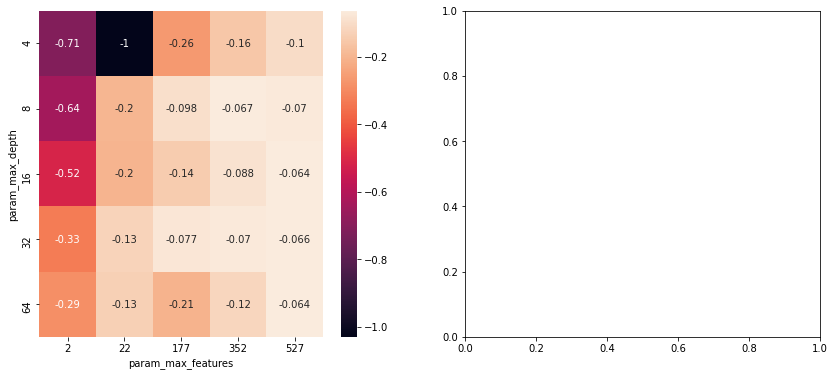

├── Uber_location_price_data (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 32, 'max_features': 5}


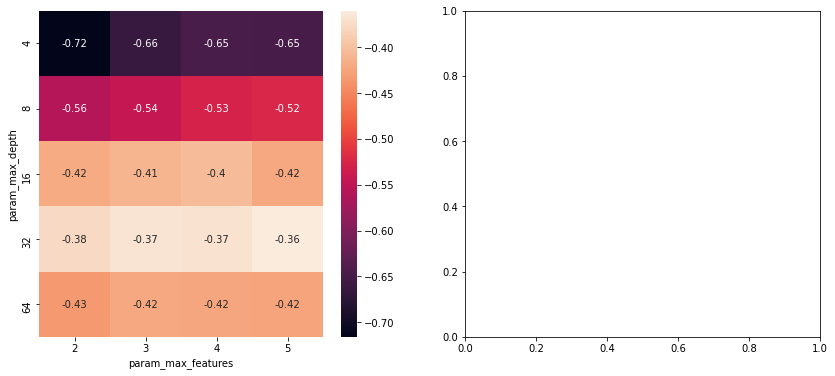

├── YearPredictionMSD_Dataset (target index = 0)
│   └── DecisionTreeRegressor...
       {'max_depth': 8, 'max_features': 90}


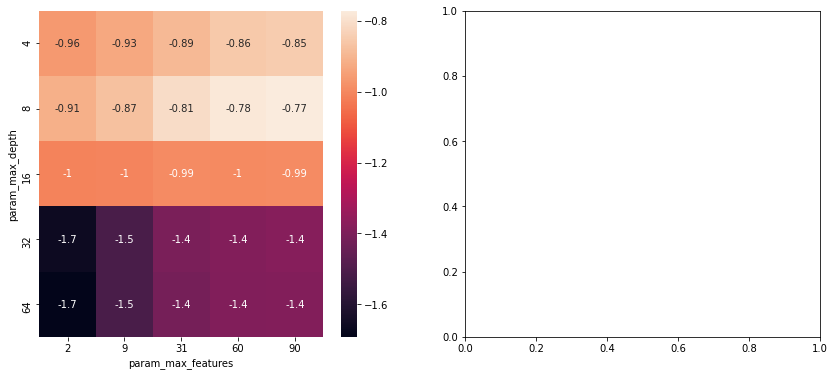

In [23]:
for dataset_path, index_path in zip(datasets_paths, indexes_paths):
    target_var_index = None
    with open(index_path) as f:
        target_var_index = int(f.readline())

    print('├── ' + dataset_path.split('/')[3] + ' (target index = ' + str(target_var_index) + ')')
    full_data = pd.read_csv(dataset_path)
    X = full_data.drop(full_data.columns[target_var_index], axis=1)
    Y = full_data[full_data.columns[target_var_index]]

    X = normalize(X)
    Y = box_cox(Y)
    Y = Y.ravel()

    print('│   └── DecisionTreeRegressor...')
    values_to_explore = list(map(int, np.linspace(2, X.shape[1], num=4)))
    values_to_explore.append(int(np.sqrt(X.shape[1])))
    values_to_explore = np.unique(values_to_explore)
    decision_tree_regr_grid['max_features'] = values_to_explore
    
    grid = GridSearchCV(estimator = DecisionTreeRegressor(),
                        param_grid = decision_tree_regr_grid,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1)
    grid.fit(X, Y)

    print('       ' + str(grid.best_params_))
    generate_heatmap(grid.cv_results_, 'param_max_depth', 'param_max_features')

    del grid, X, Y, full_data
    gc.collect()